In [1]:
import numpy as np
import os, sys
import torch
import torchviz
from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp

from time import time
%run maze_generation.ipynb import *


C:\Users\db2admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


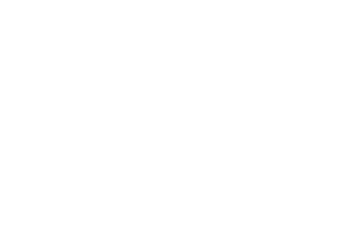

In [2]:
maze_data = np.load("./data/mazes.npy", allow_pickle=True)[()]
solution_data = np.load("./data/solutions.npy", allow_pickle=True)[()]
batch_i = 0
plt.axis('off')
def load_batch(n):
    global batch_i
    mz = torch.Tensor(maze_data[batch_i:batch_i+n]).unsqueeze(1)
    soln = torch.Tensor(solution_data[batch_i:batch_i+n]).unsqueeze(1)   
    batch_i += n
    return mz, soln

((-1, 1, 32, 32), (-1, 1, 32, 32))

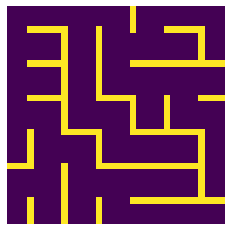

In [3]:
mazes, solutions = load_batch(2)
maze = mazes[0].squeeze()
maze2 = mazes[1].squeeze()

plt.axis("off")
plt.imshow(maze)
MAZE_SHAPE = maze.shape
BATCH_SIZE = 2

def get_maze_shape(maze, n=None, channels=True):
    result = []
    if n is None:
        result.append(-1)
    elif n > 0:
        result.append(n)
    if channels == True:
        result.append(1)
    result.append(maze.shape[0])
    result.append(maze.shape[0])
    return tuple(result)
get_maze_shape(maze), get_maze_shape(maze2), 

torch.Size([1, 1, 32, 32])

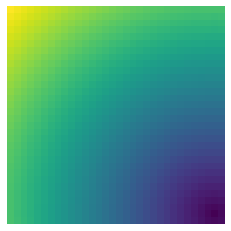

In [4]:
# We have a static start and end goal, so our H map will always look as follows:
def get_h_map(maze):
    h = torch.zeros(maze.shape)
    for i in range(len(h)):
        for j in range(len(h)):
            h[i][j] = np.linalg.norm(np.asarray([i,j]) - np.asarray([len(maze) - 2, len(maze) - 2]))
    return h / torch.max(h)

h = get_h_map(maze)
plt.axis("off")
plt.imshow(h)
h = h.reshape(-1,1,maze.shape[0], maze.shape[0])
h.shape

# Node Selection

### A differentiable operation designed to select the lowest cost node.
$V^* = I_{max}
(\frac{exp(-(G+H)/\tau) \odot O}{\langle exp(-G+H)/\tau),O\rangle}) $

    input:
        o (1d Tensor): 1d Tensor indicating status of node within the openset
        g (1d Tensor): 1d Tensor indicating the g-score associated to a node
        h (1d Tensor): 1d Tensor indicating heuristic cost of reaching the end node from each point
        
    output:
        (int): index of the lowest cost node in the flattened tensor

In [5]:
"""
NODE SELECTION: Matrix of maps
-Not done very effectively; very hacked together (w.r.t. for loop instead of matmul)
-Should be done with .flatten(start_dim=2) and performed in parallel
"""
def node_selection(o,g,h):
    results = []
    for i in range(len(o)):
        o_ = o[i]
        g_ = g[i]
        h_ = h[i]
        
        tau = np.sqrt(len(o_))
        try:
            numerator = (torch.exp(-(g_.flatten() + h_.flatten())/tau) * o_.float().flatten())
            denomenator = (torch.exp(-(g_.flatten() + h_.flatten())/tau) @ o_.float().T.flatten())
        except:
            print(g_.shape, h_.shape)
            raise Exception()
            
        v_star = numerator/denomenator
        results.append(v_star.flatten().argmax())
    return results

# Select the lowest g/h score node for two mazes
np.random.seed(1)
o = torch.Tensor(np.random.randint(0,2,2*len(maze)**2).reshape((2,1,len(maze),len(maze)))).float()
g = torch.Tensor(np.random.rand(2*len(maze)**2).reshape((2,1,len(maze),len(maze))))
hi = torch.Tensor(np.random.rand(2*len(maze)**2).reshape((2,1,len(maze),len(maze))))
o.flatten(start_dim=2)[0,0,133] = 1
o.flatten(start_dim=2)[1,0,418] = 1
g.flatten(start_dim=2)[0,0,133] = 0
g.flatten(start_dim=2)[1,0,418] = 0
hi.flatten(start_dim=2)[0,0,133] = 0
hi.flatten(start_dim=2)[1,0,418] = 0
v_star = node_selection(o,g,hi)
print(v_star, g.dtype)
o.shape, g.shape, hi.shape

[tensor(133), tensor(418)] torch.float32


C:\Users\db2admin\AppData\Local\Temp\ipykernel_18428\1904459708.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  denomenator = (torch.exp(-(g_.flatten() + h_.flatten())/tau) @ o_.float().T.flatten())


(torch.Size([2, 1, 32, 32]),
 torch.Size([2, 1, 32, 32]),
 torch.Size([2, 1, 32, 32]))

# Node Expansion
### Expand the search to include the nodes that neighbour the selected node

In [6]:
def get_v_star_I(v_star, square=False, channels=False):
    vi = torch.stack([torch.zeros(maze.shape).flatten() for m in v_star])
    for vs in enumerate(v_star):
        vi[vs[0], vs[1]] = 1
    if square==True:
        vi = vi.reshape(get_maze_shape(maze,channels=channels))
    return vi

def node_expansion(v_star, cells, o, c):
    # Create the kernel
    K = torch.Tensor([[[[1,1,1],[1,0,1],[1,1,1]]]])
    
    # Get the indicator vector from the 
    v_star_I = get_v_star_I(v_star).reshape((-1,1,len(maze),len(maze)))

    # Perform the convolution
    v_nbr = torch.nn.functional.conv2d(v_star_I.reshape((-1,1,len(maze),len(maze))), K, padding=1)
    
    # Exclude walls, and elements in the closed set:
    v_nbr = v_nbr * (1 - cells) * (1 - o.detach()) * (1 - c)
    v_bar_nbr = v_nbr * (1 - cells) * (o.detach()) * (1 - c)
    
    return v_nbr, v_bar_nbr

mazes = torch.stack([torch.Tensor(maze), torch.Tensor(maze2)]).reshape(-1,1,maze.shape[0], maze.shape[0])
v_star_I = get_v_star_I(v_star)
    
o = torch.zeros(get_maze_shape(maze, n=2), dtype=torch.float32)    
c = torch.zeros(get_maze_shape(maze, n=2), dtype=torch.float32)
    
v_nbr, v_bar_nbr = node_expansion(v_star, mazes, o, c)
v_nbr.shape, v_bar_nbr.shape, v_star, mazes.shape, o.shape, c.shape

(torch.Size([2, 1, 32, 32]),
 torch.Size([2, 1, 32, 32]),
 [tensor(133), tensor(418)],
 torch.Size([2, 1, 32, 32]),
 torch.Size([2, 1, 32, 32]),
 torch.Size([2, 1, 32, 32]))

v_star_I


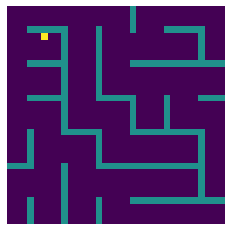

In [7]:
print("v_star_I")
plt.axis("off")
plt.imshow(maze + v_star_I[0].numpy().reshape((maze.shape[0],maze.shape[0]))*2)

node expansion


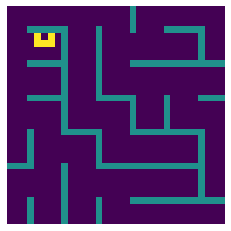

In [8]:
print("node expansion")
plt.axis("off")
plt.imshow(maze + v_nbr[0].detach().numpy().reshape((maze.shape[0],maze.shape[0]))*2)

# Updating Guidance Costs

Updated guidance costs
g torch.Size([2, 1, 32, 32])
torch.Size([2, 1, 32, 32])


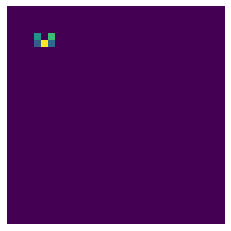

In [9]:
def update_guidance_costs(v_star, 
                          v_nbr, 
                          v_bar_nbr, 
                          phi, 
                          g):
    v_star_I = get_v_star_I(v_star)
    
    # Temporary; needs to be in x,x,r,c for batching
#     v_nbr = v_nbr.reshape(g.shape)
#     v_bar_nbr = v_bar_nbr.reshape(g.shape)
    global BATCH_SIZE
    try:
        gp = g @ v_star_I.reshape(get_maze_shape(maze,n=BATCH_SIZE,channels=True)) + phi
    except:
        print(g.shape, v_star_I.T.shape, phi.shape)
        raise Exception()
        
    g = gp * v_nbr + torch.minimum(g, gp) * v_bar_nbr
    g = g + g * (torch.ones(g.shape) - v_nbr - v_bar_nbr)
    return g.float()

print("Updated guidance costs")
print("g", g.shape)
phi = np.random.rand(len(g.flatten())).reshape(g.shape)
phi = torch.Tensor(phi)
new_g = update_guidance_costs(v_star, v_nbr, v_bar_nbr, phi, g)
print(new_g.shape)
plt.axis("off")
plt.imshow(new_g.squeeze()[0].detach().numpy())


# Minibatch Training

In [10]:
def get_verification_flag(v_star, maze):
    goal_index = len(maze) ** 2 - len(maze) - 1
    n = 1 - torch.eq(torch.Tensor(v_star), goal_index).int()
    n = torch.stack([torch.full(maze.shape, n_) for n_ in n])
    return n.reshape(get_maze_shape(maze, n = mazes.shape[0], channels=True))

def vector_to_I(v, maze):
    v_I = torch.zeros(maze.shape)
    v_I.flatten()[v] = 1
    return v_I

goal = len(maze) ** 2 - len(maze) - 1
get_verification_flag(torch.Tensor([goal, 2]), maze)

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]])

# Backtracking

In [11]:
def backtrack(parents):
    path = torch.zeros(maze.shape)
    parent = parents[-2,-2]
    while parent != 0:
        parent = parent.int().item()
        path.flatten()[parent] = 1
        parent = parents.flatten()[parent]
    return path

# Network

In [12]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
                torch.nn.Conv2d(1, 8, 3, stride=2, padding=1),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(8, 16, 3, stride=2, padding=1),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(16, 32, 3, stride=2, padding=0),
                torch.nn.ReLU(True)
            )
        
        self.decoder = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
                torch.nn.ReLU(True),
                torch.nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
                torch.nn.ReLU(True),
                torch.nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=0)
    )
    
    def forward(self, x):
        x = x.reshape((-1,1,MAZE_SHAPE[0], MAZE_SHAPE[0]))
        y = self.encoder(x)
        z = self.decoder(y)
        return z

In [13]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(encoder_name="vgg16_bn", 
                             encoder_weights=None, 
                             classes=1,
                             in_channels=1,
                             encoder_depth=3,
                             decoder_channels=[128, 64, 32])
    def forward(self, x):
        return torch.sigmoid(self.model(x))

# Putting it together

In [14]:
# create new network
net = UNet()

In [15]:
batch_i = 0
mazes, solutions = load_batch(BATCH_SIZE)

# compute phi from the encoder
phi = net(torch.Tensor(mazes))*2
batch_shape = get_maze_shape(maze, n = mazes.shape[0], channels=True)

# initialize the openset, closed set, guidance map, parents
o = torch.zeros(batch_shape, dtype=torch.float32)
c = torch.zeros(batch_shape, dtype=torch.float32)
g = torch.zeros(batch_shape, dtype=torch.float32)

# initialize h map
h = get_h_map(maze)
h = torch.stack([h for _ in range(batch_shape[0])])
h = h.reshape(-1,1,maze.shape[0], maze.shape[0])

parents = torch.zeros(batch_shape)

# initialize goal
for openset in o:
    openset[0,1,1] = 1

for i in range(1000):
    # Perform node selection
    v_star = node_selection(o,g,h)

    # Get verification flags (computing n)
    n = get_verification_flag(v_star, maze)

    # Update open-set / closed-set
    v_star_I = get_v_star_I(v_star, square=True, channels=True)
    o = o - n * v_star_I.reshape(batch_shape).float()
    c = c + n * v_star_I.reshape(batch_shape).float()

    # Expand the node neighbourhood, update open-set
    v_nbr, v_bar_nbr = node_expansion(v_star, mazes, o, c)
    o = o + v_nbr

    # Update g
    g = update_guidance_costs(v_star, v_nbr, v_bar_nbr, phi, g)

    # Update parents
    for j in range(len(v_nbr)):
        for ix in np.nonzero(v_nbr[j][0]):
            parents[j][0][ix[0]][ix[1]] = v_star[j]
    
    # If all our verification flags return as false; we're done. Exit.
    if torch.all(torch.Tensor([x.all() for x in n.squeeze()]) == False) == True:
        break
print(i)

644


(tensor(0.1502, grad_fn=<MinBackward1>),
 tensor(1.9148, grad_fn=<MaxBackward1>))

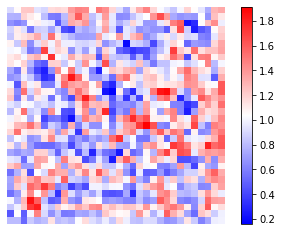

In [16]:
# Guidance Map
plt.axis("off")
plt.imshow(phi[0].squeeze().detach().numpy(), cmap=plt.cm.bwr)
plt.colorbar()
phi.min(), phi.max()


(tensor(0.1502, grad_fn=<MinBackward1>),
 tensor(1.9148, grad_fn=<MaxBackward1>))

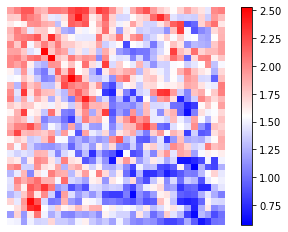

In [17]:
# Guidance map overlayed on h-cost map
plt.axis("off")
plt.imshow(phi[0].squeeze().detach().numpy() + h[0].squeeze().detach().numpy(), cmap=plt.cm.bwr)
plt.colorbar()
phi.min(), phi.max()

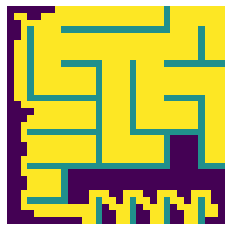

In [18]:
# Examining the closed sets
i = 1
plt.axis("off")
plt.imshow(c[i].squeeze().numpy()*2 + mazes[i].squeeze().numpy())

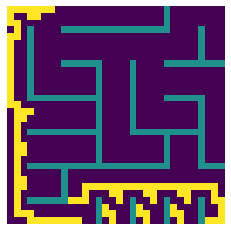

In [19]:
# Examining the open sets
plt.axis("off")
plt.imshow(o[i].squeeze().numpy()*2 + mazes[i].squeeze().numpy())

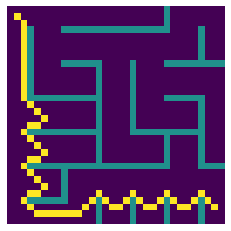

In [20]:
# Differentiable A* solution
plt.axis("off")
plt.imshow(backtrack(parents.squeeze()[i])*2 + mazes[i].squeeze())

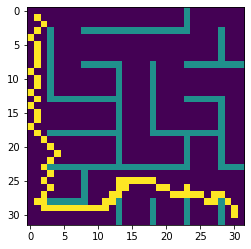

In [21]:
# A* Solution
plt.imshow(mazes[i].squeeze() + solutions[i].squeeze()*2)

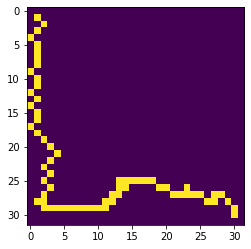

In [22]:
plt.imshow(solutions[i].squeeze())

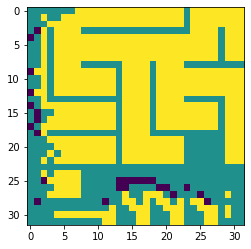

In [23]:
# Example of Loss
loss = c[i].squeeze() - solutions[i].squeeze()
plt.imshow(loss.detach().numpy())

# Training
##### The weights currently don't change  (see video/paper for further explanation, and below for debugging)

In [26]:
# Network Parameters
batch_i = 0
BATCH_SIZE = 8
lr = 0.5

net = UNet()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
loss_fn = torch.nn.MSELoss()

train_loss = []

for epoch in range(10):
    print(f"Starting epoch {epoch}\n","="*30)
    batch_i = 0
    it = 0
    # iterate until out of mazes/solutions; then go to the next epoch. //b*b helps us ensure we 
    # operate within multiples of the batch size
    epoch_start = time()
    while batch_i < len(maze_data[:8]) // BATCH_SIZE * BATCH_SIZE:
        it_start = time()
        it += 1            
        
        # load mazes and solutions
        mazes, solutions = load_batch(BATCH_SIZE)
        optimizer.zero_grad()

        # compute phi from the encoder
        phi = net(torch.Tensor(mazes))*2
        batch_shape = get_maze_shape(maze, n = mazes.shape[0], channels=True)

        # initialize the openset, closed set, guidance map, parents
        o = torch.zeros(batch_shape, dtype=torch.float32)
        c = torch.zeros(batch_shape, dtype=torch.float32, requires_grad=True)
        c.retain_grad()
        g = torch.zeros(batch_shape, dtype=torch.float32)

        # initialize h map
        h = get_h_map(maze)
        h = torch.stack([h for _ in range(batch_shape[0])])
        h = h.reshape(-1,1,maze.shape[0], maze.shape[0])

        parents = torch.zeros(batch_shape)

        # initialize goal
        for openset in o:
            openset[0,1,1] = 1

        # 1000 is max number before we cancel incase we hit a weird loop (max should be 23x23)
        for i in range(1000):
            # Perform node selection
            v_star = node_selection(o,g,h)

            # Get verification flags (computing n)
            n = get_verification_flag(v_star, maze)

            # Update open-set / closed-set
            v_star_I = get_v_star_I(v_star, square=True, channels=True)
            o = o - n * v_star_I.reshape(batch_shape).float()
            c = c + n * v_star_I.reshape(batch_shape).float()

            # Expand the node neighbourhood, update open-set
            v_nbr, v_bar_nbr = node_expansion(v_star, mazes, o, c)
            o = o + v_nbr

            # Update g
            g = update_guidance_costs(v_star, v_nbr, v_bar_nbr, phi, g)

            # Update parents
            for j in range(len(v_nbr)):
                for ix in np.nonzero(v_nbr[j][0]):
                    parents[j][0][ix[0]][ix[1]] = v_star[j]

            # If all our verification flags return as false; we're done. Exit.
            if torch.all(torch.Tensor([x.all() for x in n.squeeze()]) == False) == True:
                break
        # calculate loss; closed sets are the output, solutions are the target
        loss = loss_fn(c.squeeze(), solutions.squeeze())

        # back propagate
        loss.backward()

        # take an optimization step
        optimizer.step()
                    
        # print
        if it % 1 == 0:
            print(f"{it:3d}/{len(maze_data) // BATCH_SIZE} - duration: {time() - it_start:4.2f} - loss: {loss.item()}")
        train_loss.append(loss.detach().cpu().numpy())

Starting epoch 0
  1/125 - duration: 4.10 - loss: 0.2298583984375
Starting epoch 1
  1/125 - duration: 4.12 - loss: 0.2298583984375
Starting epoch 2
  1/125 - duration: 4.48 - loss: 0.2298583984375
Starting epoch 3
  1/125 - duration: 4.26 - loss: 0.2298583984375
Starting epoch 4
  1/125 - duration: 4.37 - loss: 0.2298583984375
Starting epoch 5
  1/125 - duration: 4.49 - loss: 0.2298583984375
Starting epoch 6
  1/125 - duration: 4.18 - loss: 0.2298583984375
Starting epoch 7
  1/125 - duration: 4.43 - loss: 0.2298583984375
Starting epoch 8


KeyboardInterrupt: 

In [ ]:
c.grad

# Debugging Attempt with Tensorboard
##### Doesn't work; gradients are being passed correctly

In [ ]:
# Network Parameters
batch_i = 0
BATCH_SIZE = 8
lr = 0.5

net = UNet()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
loss_fn = torch.nn.MSELoss()

# Debugging tools
writer = SummaryWriter()
forwards = {}
backwards = {}
def forward_hook_fn(m, i, o):
    forwards[m] = o 
def backward_hook_fn(m, i, o):
    backwards[m] = o
    
for name_, layer_ in net._modules.items():
    for name, layer in layer_._modules.items():
        layer.register_forward_hook(forward_hook_fn)      
        layer.register_full_backward_hook(backward_hook_fn)
    
train_loss = []

for epoch in range(10):
    print(f"Starting epoch {epoch}\n","="*30)
    batch_i = 0
    it = 0
    
    # iterate until out of mazes/solutions; then go to the next epoch. //b*b helps us ensure we 
    # operate within multiples of the batch size
    epoch_start = time()
    while batch_i < len(maze_data[:8]) // BATCH_SIZE * BATCH_SIZE:
        it_start = time()
        it += 1            
        
        # load mazes and solutions
        mazes, solutions = load_batch(BATCH_SIZE)
        optimizer.zero_grad()

        # compute phi from the encoder
        phi = net(torch.Tensor(mazes))*2
        batch_shape = get_maze_shape(maze, n = mazes.shape[0], channels=True)

        # initialize the openset, closed set, guidance map, parents
        o = torch.zeros(batch_shape, dtype=torch.float32, requires_grad=True)
        c = torch.zeros(batch_shape, dtype=torch.float32, requires_grad=True)        
        g = torch.zeros(batch_shape, dtype=torch.float32, requires_grad=True)
        
        o.retain_grad()
        c.retain_grad()
        g.retain_grad()

        # initialize h map
        h = get_h_map(maze)
        h = torch.stack([h for _ in range(batch_shape[0])])
        h = h.reshape(-1,1,maze.shape[0], maze.shape[0])
        h.requires_grad = True
        h.retain_grad()

        parents = torch.zeros(batch_shape)

        # initialize goal
#         for openset in o:
#             openset[0,1,1] = 1
        for i in range(len(o)):
            o.data[i,0,1,1] = 1

        # 1000 is max number before we cancel incase we hit a weird loop (max should be 23x23)
        for i in range(1000):
            # Perform node selection
            v_star = node_selection(o,g,h)

            # Get verification flags (computing n)
            n = get_verification_flag(v_star, maze)

            # Update open-set / closed-set
            v_star_I = get_v_star_I(v_star, square=True, channels=True)
            v_star_I.requires_grad = True
            v_star_I.retain_grad()
            
            o = o - n * v_star_I.reshape(batch_shape).float()
            c = c + n * v_star_I.reshape(batch_shape).float()
            c.retain_grad()

            # Expand the node neighbourhood, update open-set
            v_nbr, v_bar_nbr = node_expansion(v_star, mazes, o, c)
            o = o + v_nbr

            # Update g
            g = update_guidance_costs(v_star, v_nbr, v_bar_nbr, phi, g)

            # Update parents
            for j in range(len(v_nbr)):
                for ix in np.nonzero(v_nbr[j][0]):
                    parents[j][0][ix[0]][ix[1]] = v_star[j]

            # If all our verification flags return as false; we're done. Exit.
            if torch.all(torch.Tensor([x.all() for x in n.squeeze()]) == False) == True:
                break
                
        # calculate loss; closed sets are the output, solutions are the target
        loss = loss_fn(c, solutions)

        # back propagate
        loss.backward()

        # take an optimization step
        optimizer.step()

        # capture debug info
        if it % 1 == 0:
            for name, weight in net.named_parameters():
                try:
                    writer.add_histogram(name, weight, it)
                    writer.add_histogram(f"{name}-gradient", weight.grad, it)  
                except:
                    print(name)
                    raise Exception()
                    
                    
        # print
        if it % 1 == 0:
            print(f"{it:3d}/{len(maze_data) // BATCH_SIZE} - duration: {time() - it_start:4.2f} - loss: {loss.item()}")
        train_loss.append(loss.detach().cpu().numpy())

In [ ]:
c.grad.shape

In [ ]:
net.model.encoder.features[0].weight.shape

In [ ]:
net.model.encoder.features[0].weight.grad.shape

In [ ]:
torchviz.make_dot(phi, params=dict(net.named_parameters()), show_attrs=True).render("./gradients")